In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [ ]:
import os
import io
from google.colab import files
uploaded = files.upload()
# df2 = pd.read_csv(io.BytesIO(uploaded['D:/tensflow/BrentOilPrices.csv']))


Saving BrentOilPrices.csv to BrentOilPrices (1).csv


In [ ]:
# df=pd.read_csv(BrentOilPrices.csv)

df= pd.read_csv(io.BytesIO(uploaded['BrentOilPrices.csv']))

In [ ]:
df.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


In [ ]:
df.isnull().sum()

Date     0
Price    0
dtype: int64

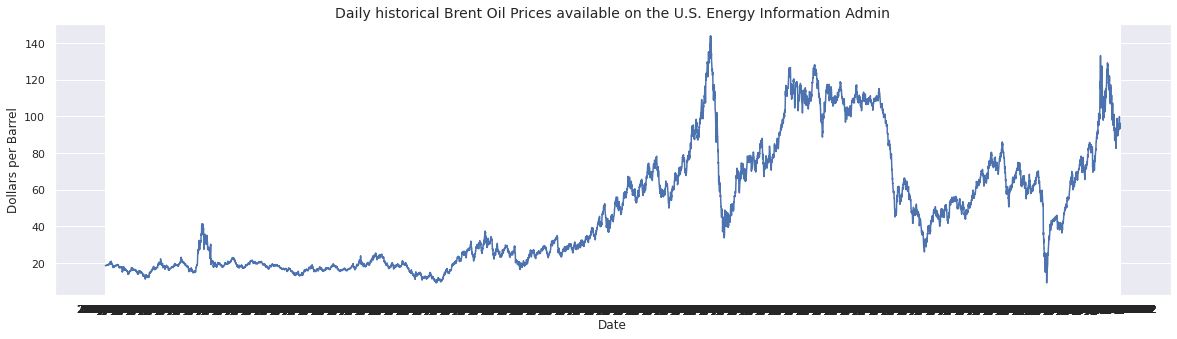

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # using seaborn because the charts are more visually pleasing

sns.set_theme(style="darkgrid")
plt.figure(figsize=(20,5))
sns.lineplot(x="Date", y="Price", data=df)
plt.title('Daily historical Brent Oil Prices available on the U.S. Energy Information Admin', fontsize=14)
plt.ylabel('Dollars per Barrel')
plt.show()

In [ ]:
df.describe()

,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


In [ ]:
# Creating a simple moving average for 7 and 21 days
df['ma7'] = df.Price.rolling(window=7).mean()
df['ma21'] = df.Price.rolling(window=21).mean()

# Creating the EMA
df['ema12'] = df.Price.ewm(span=12).mean().fillna(0)
df['ema26'] = df.Price.ewm(span=26).mean().fillna(0)
df['macd'] = df.ema12 - df.ema26

#The variables below are used for Bollinger Bands.
window=21
no_std = 2
rolling_mean = df.Price.rolling(window).mean()
rolling_std = df.Price.rolling(window).std()
df['bollinger_low'] = (rolling_mean - (rolling_std * no_std)).fillna(0)
df['bollinger_high'] = (rolling_mean + (rolling_std * no_std)).fillna(0)
df['ema'] = df.Price.ewm(com=0.5).mean()
df['momentum'] =  df.Price - 1

df.head()

,Date,Price,ma7,ma21,ema12,ema26,macd,bollinger_low,bollinger_high,ema,momentum
0,20-May-87,18.63,NaN,NaN,18.630000,18.630000,0.000000,0.0,0.0,18.630000,17.63
1,21-May-87,18.45,NaN,NaN,18.532500,18.536538,-0.004038,0.0,0.0,18.495000,17.45
2,22-May-87,18.55,NaN,NaN,18.539330,18.541375,-0.002045,0.0,0.0,18.533077,17.55
3,25-May-87,18.60,NaN,NaN,18.558481,18.557764,0.000717,0.0,0.0,18.578250,17.60
4,26-May-87,18.63,NaN,NaN,18.577913,18.574516,0.003397,0.0,0.0,18.612893,17.63


In [ ]:
scalerz = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = scalerz.fit_transform(df.Price.values.reshape(-1, 1))

In [ ]:
splitz =0.7
train_size = int(len(dataset) * splitz)
test_size = int(len(dataset) * (1-splitz))
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
f'Dataset size: {len(df)} >> Train length: {len(train)} || Test Length: {len(test)}'

'Dataset size: 9011 >> Train length: 6307 || Test Length: 2704'

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
x_train, y_train = create_dataset(train, look_back=15)
x_test, y_test = create_dataset(test, look_back=15)
f'X_train: {x_train.shape} || \
y_train: {y_train.shape} || \
X_test: {x_test.shape} || \
y_test: {y_test.shape}'

'X_train: (6291, 15) || y_train: (6291,) || X_test: (2688, 15) || y_test: (2688,)'

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
f'X_train: {x_train.shape} || \
y_train: {y_train.shape} || \
X_test: {x_test.shape} || \
y_test: {y_test.shape}'

'X_train: (6291, 1, 15) || y_train: (6291,) || X_test: (2688, 1, 15) || y_test: (2688,)'

In [ ]:
# create and fit the LSTM network
look_back = 15
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


# Simple early stopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# mc = ModelCheckpoint('best_model.h5', 
# monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
6291/6291 - 19s - loss: 0.0018 - 19s/epoch - 3ms/step
Epoch 2/20
6291/6291 - 13s - loss: 2.5390e-04 - 13s/epoch - 2ms/step
Epoch 3/20
6291/6291 - 13s - loss: 1.8378e-04 - 13s/epoch - 2ms/step
Epoch 4/20
6291/6291 - 13s - loss: 1.7015e-04 - 13s/epoch - 2ms/step
Epoch 5/20
6291/6291 - 17s - loss: 1.5606e-04 - 17s/epoch - 3ms/step
Epoch 6/20
6291/6291 - 18s - loss: 1.4943e-04 - 18s/epoch - 3ms/step
Epoch 7/20
6291/6291 - 14s - loss: 1.3780e-04 - 14s/epoch - 2ms/step
Epoch 8/20
6291/6291 - 14s - loss: 1.3667e-04 - 14s/epoch - 2ms/step
Epoch 9/20
6291/6291 - 15s - loss: 1.2354e-04 - 15s/epoch - 2ms/step
Epoch 10/20
6291/6291 - 14s - loss: 1.3090e-04 - 14s/epoch - 2ms/step
Epoch 11/20
6291/6291 - 17s - loss: 1.1767e-04 - 17s/epoch - 3ms/step
Epoch 12/20
6291/6291 - 15s - loss: 1.1633e-04 - 15s/epoch - 2ms/step
Epoch 13/20
6291/6291 - 16s - loss: 1.1528e-04 - 16s/epoch - 3ms/step
Epoch 14/20
6291/6291 - 14s - loss: 1.1354e-04 - 14s/epoch - 2ms/step
Epoch 15/20
6291/6291 - 14s - los

In [ ]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)

# invert predictions
trainPredict = scalerz.inverse_transform(trainPredict)
trainY = scalerz.inverse_transform([y_train])
testPredict = scalerz.inverse_transform(testPredict)
testY = scalerz.inverse_transform([y_test])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

84/84 [==============================] - 0s 2ms/step
Train Score: 1.14 RMSE
Test Score: 1.69 RMSE


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix, classification_report


print('R2 Score: ', r2_score(testY[0], testPredict[:,0]))

R2 Score:  0.9957852882304559


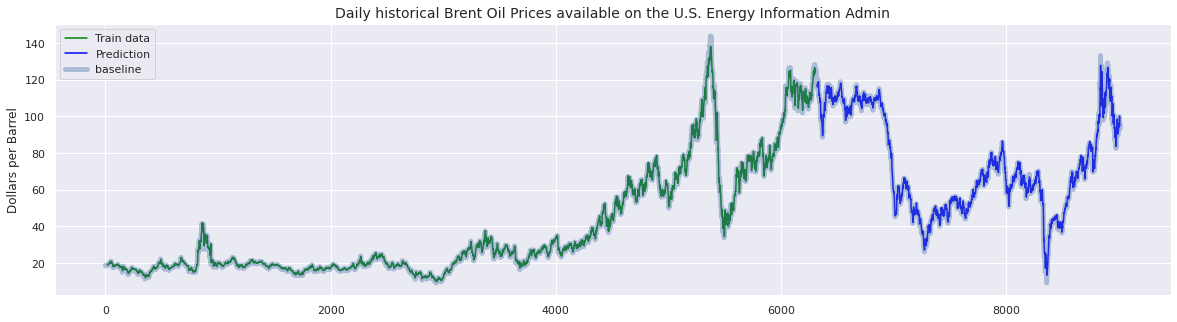

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(20,5))
plt.plot(trainPredictPlot, color='green', label='Train data')
plt.plot(testPredictPlot, color='blue', label='Prediction',)
plt.plot(scalerz.inverse_transform(dataset),label='baseline', alpha=0.4, linewidth=5)
plt.title('Daily historical Brent Oil Prices available on the U.S. Energy Information Admin', fontsize=14)
plt.ylabel('Dollars per Barrel')
plt.legend()
plt.show()